# **Interpretable Predictions.**

### PANAGIOTIS KAFANTARIS ADVANCED CUSTOMER ANALYTICS PROJECT 1.

**Περιγραφή:**

**Step 1:** Find (or scrape) an online dataset that encodes customer/user preferences with respect to various entities (e.g. products, services). Examples include:

* datasets with reviews/ratings,

* sales-based datasets,

* clickthrough (CTR) datasets,

* datasets that encode user interactions with different pieces of content (e.g. listening spotify songs, liking/sharing posts or IG or Twitter).

The dataset should definitely include descriptive attributes for the entities. For the users, it should have either descriptive attributes or a history of their past interactions with entities.

**Step 2:** Record your name and dataset here. You can't pick a dataset that has already been recorded by another student.

**Step 3:** Create a Python Notebook that trains a binary classifier that can predict if a specific user will be interested in a specific entity. The notebook should implement (at least) the following functions:

* A function that reads a training dataset and trains the binary predictor

* A function that accepts a user and an entity and returns the binary prediction, as well as an explanation (justification) for that prediction.  If the prediction
is negative, the function should use counterfactuals to suggest how the entity would have to change to yielf a positive prediction.

## **Solution:**

In this project, we aim to develop a comprehensive solution that combines API scraping with a user preference model to provide tailored recommendations. Specifically, we gather data from Spotify’s API to analyze musical attributes, which serve as the foundation for constructing a preference model that understands and predicts user tastes. This approach allows us to bridge data-driven insights with personalized user experiences.

## **Instructions**

1. Pre-processed CSV Files:

   * To save time and avoid re-executing lengthy processes, pre-processed CSV files containing the required data are included. These files store data that was previously retrieved from Spotify’s API and processed for analysis.

   * Use these CSVs as input for subsequent steps in the project to bypass redundant data collection.

2. Data Gathering:
   * If you wish to gather fresh data, you can execute the scraping scripts. However, keep in mind that data retrieval from APIs might be time-consuming, especially when dealing with large datasets.
   * Go to https://developer.spotify.com/ and create the CLIENT_ID and CLIENT_SECRET.
   * **For audio features it became impossible to fetch since 27th of November because Spotify decided to depracate the endpoint.**

3. Running the User Preference Model:
   * Once the CSV data is loaded, the user preference model can be initialized. This model uses the data to identify patterns and deliver personalized recommendations based on user input.
4. File Organization:
   * Ensure that all CSV files are uploaded.

Install All necessary libraries

In [ ]:
!pip install pyngrok
!pip install spotipy

In [ ]:
import spotipy
from spotipy.exceptions import SpotifyException
import spotipy
spotipy.trace = True
spotipy.trace_out = True
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
import pandas as pd
from pyngrok import ngrok
import pandas as pd
import os
from urllib.parse import urlparse, parse_qs
from tqdm import tqdm
import csv
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import re

##**Approach:**

We will scrape data using the **Spotify API**. To get started, we need to establish a connection to the API. An alternative, more advanced method is also provided. Its purpose was for retreiving track's feature. However since endpoint's deprecation, it is redundant as a method but we say a few words because of its potential usefulness in the future.

Before proceeding, ensure you have entered your Client ID and Client Secret. These credentials are essential for accessing the API.

In [ ]:
CLIENT_ID = "YOUR_CLIENT_ID"
CLIENT_SECRET = "YOUR_CLIENT_SECRET"
SCOPE = "user-library-read playlist-read-private playlist-read-collaborative"
REDIRECT_URI = ""

##**CONNECT TO API:**

We will use Spotipy, a lightweight Python library, to handle authorization with the Spotify API. If you experience issues logging in, double-check your credentials (Client ID and Client Secret).

You can also enable an alternative method by setting `with_scope=True`. This method utilizes ngrok, a tool that creates a secure tunnel to expose your local server to the internet. Ngrok generates a public URL that Spotify can use for its API callback during the authentication process.

This method is particularly useful if your local setup encounters connection issues or if you need a temporary, accessible endpoint for Spotify's OAuth flow.

In [ ]:
with_scope = False

Helper Function to get the code from the URL (Only for alternative method)

In [ ]:
def extract_code_from_url(url):
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    return query_params.get("code", [None])[0]

### **ALTERNATIVE METHOD:**

To securely expose our local server to the internet, we will use ngrok. This allows us to create a public URL that Spotify can use for callbacks during the authentication process. The function below handles the setup by connecting ngrok to port 8080.

Replace the NGROK_AUTH_TOKEN (no need to do that) with your personal token to establish the connection.

For more info about NGROK and how to create a new authentication token visit: https://ngrok.com/

If no altrernative method is required you dont need to provide the token and you can continue without this step. Run the code and go to next cells.

In [ ]:
def get_ngrok_url():
    NGROK_AUTH_TOKEN = "YOUR_NGROK_AUTH_TOKEN"
    try:
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
        public_url = ngrok.connect(8080).public_url
        return public_url
    except Exception as e:
        print(f"Error starting ngrok: {e}")
        return None

In [ ]:
# HERE WE WOULD START OUR CONNECTION

# public_url = get_ngrok_url()
# if public_url is None:
#     print("Failed to get ngrok URL. Exiting.")
# else:
#     REDIRECT_URI = f"{public_url}/callback"
#     print(f"Redirect URI: {REDIRECT_URI}")

The `setup_spotify_oauth` function handles Spotify API authentication. It supports two modes of authorization:

Without Scope (`with_scope=False`):

* In this mode, the app uses the SpotifyClientCredentials flow, which does not require user-specific authentication.

With Scope (`with_scope=True`):

* If enabled, this mode utilizes Spotify's OAuth flow with a specified redirect_uri and permissions (scope).

Ensure that your CLIENT_ID, CLIENT_SECRET, redirect_uri, and scope are correctly configured.

The function intelligently selects the appropriate authentication flow based on the `with_scope` parameter, providing flexibility.

In [ ]:
def setup_spotify_oauth(with_scope = True, redirect_uri=REDIRECT_URI, scope=SCOPE):
    if with_scope and redirect_uri != "" and scope:
      print('Alternative method')
      return SpotifyOAuth(
          client_id=CLIENT_ID,
          client_secret=CLIENT_SECRET,
          redirect_uri=redirect_uri,
          scope=scope,
          requests_timeout=10
      )
    else:
      return spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET))

The `authenticate_user` function handles the Spotify user authentication process. It provides two modes of operation based on the with_scope parameter:

***(BASIC METHOD)***
Without Scope (with_scope=False):

* Returns a client credentials-based authentication object for accessing public data without user-specific permissions.

No further user interaction is required.

***(ALTERNATIVE METHOD)***
With Scope (with_scope=True):

* Initiates Spotify's OAuth flow, allowing the application to access user-specific data or perform actions on behalf of the user.

The process involves:
* Go to https://developer.spotify.com/ -> dasboard -> Settings and change Redirect URI with the above coming from NGROK.
* Paste it to input.
* The method captures the authentication code from redirect URL after successful login.

Exchanging the code for an access token to authenticate subsequent API requests.

Upon successful login, the user's profile is retrieved and displayed as a test to make sure we logged in without any problems.

In [ ]:
def authenticate_user(with_scope=True):
    sp_oauth = setup_spotify_oauth(with_scope)

    if not with_scope:
        return sp_oauth

    auth_url = sp_oauth.get_authorize_url()
    print(f"Authorization URL: {auth_url}")

    auth_redirect_url = input("Paste the redirect URL here (after you authenticate): ")
    code = extract_code_from_url(auth_redirect_url)

    if not code:
        print("Authorization code not found in the URL. Exiting.")
        return None

    try:
        token_info = sp_oauth.get_access_token(code)
        access_token = token_info['access_token']
        sp = spotipy.Spotify(auth=access_token)
        user_profile = sp.current_user()
        print(f"Logged in as: {user_profile['display_name']}")
        #return sp, access_token
        return sp
    except Exception as e:
        print(f"Error during authentication: {e}")
        return None

In [ ]:
sp = authenticate_user(with_scope)
if not sp:
    print("Failed to authenticate. Exiting.")

# **GATHERING DATA LOGIC:**

Spotify does not allow direct access to user preferences due to GDPR regulations. This restricts us from directly retrieving user data like track preferences.

**Alternative Approach:**
To work around this, we will indirectly infer user preferences by leveraging public playlists.

1. Request Public Playlists:
  * We will query Spotify’s API for playlists using a genre keyword (e.g., Pop, Jazz, Rock).
  * Each playlist returned will be tagged with its owner ID, representing the user who created or owns the playlist.
2. Capture Unique Owner IDs:
  * Extract and store the owner IDs from the playlists.
  * Ensure there are no duplicate IDs to avoid redundant processing.
3. Fetch Playlists for Each Owner:
  * Using the unique owner IDs, we will fetch their public playlists.
  * Filter these playlists by the genre we targeted earlier.
4. Assume Liked Tracks:
  * From the filtered playlists, extract the track IDs and assume that these tracks represent the user’s preferences for the given genre.
5. Create a User-Track Mapping:
  * Build a dataset where each user is linked to the tracks they are inferred to like, based on their genre-specific playlists.
6. Fetch Track Features:
  * Using the track IDs gathered, create a new dataset containing the features of each track (e.g., danceability, energy, tempo).
  * This will serve as the foundational data for our model.
7. Combine Data for Model Training:
  * Integrate all the collected data (user IDs, genres, tracks, and track features) into a training dataset.
  * This dataset will serve as the input for our model, allowing us to predict user preferences.
8. Prepare for Model Explanation:
  * We will explain later in the notebook how the training data is structured and how it will be used to train the binary classifier.

The `search_spotify_playlists` function allows us to search Spotify for playlists that match a specific keyword.

Key Features:

Parameters:
  * keyword: The search term to look for in playlist titles.
  * limit: The number of playlists to return (default is 20).
  * offset: The starting point for the search results, enabling pagination.

In [ ]:
def search_spotify_playlists(keyword, limit=20, offset=0):
    try:
        # Use the Spotify API to search for playlists matching the keyword
        results = sp.search(q=keyword, type="playlist", limit=limit, offset=offset)

        # Extract and return the list of playlists
        return results.get('playlists', {}).get('items', [])
    except Exception as e:
        print(f"Error searching playlists for keyword '{keyword}': {e}")
        return []

The `sanitize_keyword` function ensures that the provided keyword is cleaned of any unwanted characters before being used in playlist searches. This is important to avoid issues caused by special characters and ensures consistent search behavior.

`extract_owner_ids_with_keywords`
This function extracts the owner IDs from a list of playlists and associates them with the provided keyword. The keyword is sanitized for consistency, and each owner ID is paired with the genre or category represented by the keyword.

Key Features:
1. Keyword Sanitization:
  * Removes special characters from the keyword to ensure a clean and valid search term.
2. Owner ID Extraction:
  * Iterates through the playlists and retrieves the owner ID for each.
  * Associates the owner ID with the sanitized keyword.
3. Output:
  * Returns a list of dictionaries, each containing:
      * owner_id: The ID of the playlist's owner.
      * genre: The sanitized keyword associated with the playlist.

In [ ]:
def sanitize_keyword(keyword):
    # Remove all characters except letters, numbers, and spaces
    return re.sub(r"[^\w\s]", "", keyword)

def extract_owner_ids_with_keywords(playlists, keyword):
    # Sanitize the provided keyword
    sanitized_keyword = sanitize_keyword(keyword)

    # Initialize a list to store the extracted owner IDs and associated genres
    owner_ids_with_keywords = []

    # Iterate through the playlists to extract owner IDs
    for playlist in playlists:
        # Ensure the playlist and owner data are valid
        if playlist and playlist.get('owner') and playlist['owner'].get('id'):
            # Extract the owner ID
            owner_id = playlist['owner']['id']
            # Append the owner ID and sanitized keyword as a dictionary
            owner_ids_with_keywords.append({'owner_id': owner_id, 'genre': sanitized_keyword})

    return owner_ids_with_keywords

The `search_playlists_by_genre` function allows us to search Spotify for playlists associated with a predefined list of genres or custom keywords. It iterates through the keywords, fetches playlists matching each keyword, and extracts the unique owner IDs while associating them with the corresponding genre.

Key Features:
1. It searches for popular genres like "Pop," "Rock," and "Jazz."
2. Pagination:
 * Supports Spotify's pagination mechanism using the offset parameter to fetch more playlists if available.

3. Duplication:
 * Ensures that each owner ID is included only once, even if they appear in multiple playlists.

4. Progress Tracking:
 * Utilizes a progress bar (tqdm) to visually indicate the status of the search process for each keyword.

In [ ]:
def search_playlists_by_genre(keywords=None, max_playlists=20, limit=20):
    if keywords is None:
        keywords = ['*Pop*', '*Rock*', '*Hip hop*', '*EDM*', '*Country*', '*Jazz*', '*Latin*', '*Indie*']

    owner_ids_with_keywords = []
    existing_owner_ids = set()  # Track already added owner IDs for deduplication

    with tqdm(total=len(keywords), desc="Processing Keywords", unit="keyword") as pbar:
        for keyword in keywords:
            playlists_found = 0  # Count the number of playlists processed for the current keyword
            offset = 0  # Pagination offset for Spotify API

            while playlists_found < max_playlists:
                # Fetch playlists from Spotify
                playlists = search_spotify_playlists(keyword, limit=limit, offset=offset)

                if not playlists:
                    break  # Exit loop if no more playlists are found

                # Extract owner IDs and update the result
                for owner_data in extract_owner_ids_with_keywords(playlists, keyword):
                    owner_id = owner_data['owner_id']
                    # Add only if the owner ID is not already in the list
                    if owner_id not in existing_owner_ids:
                        owner_ids_with_keywords.append(owner_data)
                        existing_owner_ids.add(owner_id)  # Mark the owner ID as added

                # Update counts and pagination
                playlists_found += len(playlists)
                if len(playlists) < limit:  # Stop if fewer playlists are returned than requested
                    break

                offset += limit

            pbar.update(1)  # Update the progress bar

    return owner_ids_with_keywords

In [ ]:
owners = search_playlists_by_genre()

Processing Keywords: 100%|██████████| 8/8 [00:01<00:00,  4.86keyword/s]


In [ ]:
list(owners)[:5]

[{'owner_id': 'j56o61v49o50jtej2b9cqptjm', 'genre': 'Pop'},
 {'owner_id': '31heeg5wrzm67nrgtehxz23z2mmq', 'genre': 'Pop'},
 {'owner_id': 'kigoty6gopjftnazhhk7e0hh5', 'genre': 'Pop'},
 {'owner_id': 'jsq8ypmzowlahoi09rbudxkrl', 'genre': 'Pop'},
 {'owner_id': '12124874489', 'genre': 'Pop'}]

In [ ]:
len(list(owners))

80

Helper function to write the data to a csv file so we can re use it later.

In [ ]:
def write_to_csv(data, filename):
    if not data:
        print(f"No data to write to {filename}.")
        return

    fieldnames = set
    fieldnames = data[0].keys()

    try:
        with open(filename, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()  # Write the header row
            writer.writerows(data)  # Write all data rows

        print(f"Data successfully written to {filename}.")
    except Exception as e:
        print(f"An error occurred while writing to {filename}: {e}")

In [ ]:
owners_filename = "Owners.csv"

In [ ]:
write_to_csv(owners, owners_filename)

Data successfully written to Owners.csv.


Helper Function to load data from a csv file.

In [ ]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [ ]:
owners = load_data(owners_filename)

The `fetch_user_playlists_by_genre` function retrieves playlists for a specific user, filtered by a specified genre. This is useful for identifying playlists curated by the user that match a particular theme or category.

Key Features:
1. User-Specific Playlists:
  * Fetches playlists belonging to a specific user (user_id).
2. Genre Filtering:
  * Filters playlists based on the presence of the genre keyword in the playlist’s name or description (case-insensitive).
3. Pagination:
  * Utilizes Spotify's pagination to fetch additional results if needed, up to the specified maximum number of playlists (max_playlists).

In [ ]:
def fetch_user_playlists_by_genre(user_id, genre, max_playlists=2, limit=20):
    playlists = []
    offset = 0
    genre_lower = genre.lower()  # Convert genre to lowercase for case-insensitive matching

    while len(playlists) < max_playlists:
        try:
            # Fetch user playlists with pagination
            results = sp.user_playlists(user_id, limit=limit, offset=offset)

            # Filter playlists by genre
            for playlist in results['items']:
                playlist_name = playlist.get('name', '').lower()
                playlist_description = playlist.get('description', '').lower()

                if genre_lower in playlist_name or genre_lower in playlist_description:
                    playlists.append(playlist)
                    if len(playlists) >= max_playlists:
                        break  # Stop if max_playlists is reached

            # Exit loop if there are no more results
            if results['next'] is None:
                break

            offset += limit
        except Exception as e:
            print(f"Error fetching playlists for user {user_id}: {e}")
            break  # Exit if an error occurs

    return playlists[:max_playlists]

The `fetch_playlist_tracks` function retrieves all unique track IDs from a given playlist. It uses Spotify's pagination mechanism to fetch tracks in batches, ensuring all tracks are captured, even for large playlists.

Key Features:
1. Playlist-Specific Tracks:
  * Fetches tracks from a specific playlist identified by its playlist_id.
2. Unique Track IDs:
  * Stores track IDs in a set to ensure uniqueness, preventing duplicates.
3. Pagination:
  * Handles large playlists by iterating through Spotify's paginated results.

In [ ]:
def fetch_playlist_tracks(playlist_id):
    track_ids = set()
    offset = 0

    while True:
        try:
            # Fetch playlist items with pagination
            results = sp.playlist_items(playlist_id, limit=20, offset=offset)
            for item in results['items']:
                track = item.get('track')
                if track and track.get('id'):
                    track_ids.add(track['id'])  # Add unique track IDs to the set

            if results['next'] is None:
                break  # Exit loop if there are no more results

            offset += 20
        except Exception as e:
            print(f"Error fetching tracks from playlist {playlist_id}: {e}")
            break  # Exit if an error occurs

    return track_ids

The `get_tracks_by_user` function retrieves all unique tracks from a specific user’s playlists that match a specified genre. This function integrates playlist filtering and track extraction into a single process, providing an efficient way to collect tracks curated by a user for a specific theme or category.

Key Features:
1. Genre-Based Playlist Filtering:
  * Filters the user’s playlists to include only those whose name or description matches the specified genre.
2. Track Collection:
  * Fetches all tracks from the filtered playlists and ensures only unique tracks are returned.

In [ ]:
def get_tracks_by_user(user_id, genre, max_playlists=2):
    try:
        # Fetch playlists for the user filtered by genre
        playlists = fetch_user_playlists_by_genre(user_id, genre, max_playlists=max_playlists)
        all_track_ids = set()

        # Fetch tracks from each playlist
        for playlist in playlists:
            playlist_name = playlist.get('name', 'Unknown Playlist')
            playlist_id = playlist['id']
            #print(f"Fetching tracks from playlist: {playlist_name} (ID: {playlist_id})")

            track_ids = fetch_playlist_tracks(playlist_id)
            all_track_ids.update(track_ids)  # Add tracks to the set

        return list(all_track_ids)
    except Exception as e:
        print(f"Error fetching tracks for user {user_id} (Genre: {genre}): {e}")
        return []  # Return an empty list if an error occurs

We then process a list of Spotify playlist owners and retrieves track data for each owner based on their associated genre. The results are stored in a dictionary (owners_tracks), where each owner's tracks and genre are recorded.

Key Features:
1. Owner-Track Mapping:
  * Iterates through the list of owners and retrieves tracks for each based on their associated genre.
2. Progress Feedback:
  * Displays real-time progress using tqdm, showing the current owner and genre being processed.

In [ ]:
# Initialize an empty dictionary to store track data for each owner
owners_tracks = {}

# Iterate over the DataFrame rows
with tqdm(total=len(owners), desc="Processing Owners", unit="owner") as pbar:
    for _, row in owners.iterrows():  # Use iterrows to get each row as a Series
        owner_id = row['owner_id']  # Access 'owner_id' column
        genre = row['genre']  # Access 'genre' column
        #print(f"Processing owner: {owner_id} (Genre: {genre})")

        try:
            # Fetch tracks for the current owner and genre
            tracks = get_tracks_by_user(owner_id, genre)
            owners_tracks[owner_id] = {'genre': genre, 'tracks': tracks}

            # Update progress bar with the current owner and genre
            pbar.set_postfix(owner=owner_id, genre=genre)
        except Exception as e:
            print(f"Error processing owner {owner_id} (Genre: {genre}): {e}")
            owners_tracks[owner_id] = {'genre': genre, 'tracks': []}  # Fallback in case of error

        pbar.update(1)  # Increment progress bar

Processing Owners:   2%|▏         | 2/87 [00:05<03:29,  2.46s/owner, genre=Pop, owner=j56o61v49o50jtej2b9cqptjm]ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/playlists/44XJR1i3Vl2B3acOEYwinE/tracks with Params: {'limit': 20, 'offset': 0, 'fields': None, 'market': None, 'additional_types': 'track,episode'} returned 404 due to Resource not found
ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/playlists/6LY1QKuuZv6rtPKsHJSsnF/tracks with Params: {'limit': 20, 'offset': 0, 'fields': None, 'market': None, 'additional_types': 'track,episode'} returned 404 due to Resource not found
Processing Owners:   3%|▎         | 3/87 [00:06<02:56,  2.10s/owner, genre=Pop, owner=spotify]

Error fetching tracks from playlist 44XJR1i3Vl2B3acOEYwinE: http status: 404, code:-1 - https://api.spotify.com/v1/playlists/44XJR1i3Vl2B3acOEYwinE/tracks?limit=20&offset=0&additional_types=track%2Cepisode:
 Resource not found, reason: None
Error fetching tracks from playlist 6LY1QKuuZv6rtPKsHJSsnF: http status: 404, code:-1 - https://api.spotify.com/v1/playlists/6LY1QKuuZv6rtPKsHJSsnF/tracks?limit=20&offset=0&additional_types=track%2Cepisode:
 Resource not found, reason: None


Processing Owners: 100%|██████████| 87/87 [04:16<00:00,  2.95s/owner, genre=Indie, owner=ansadesigner]


In [ ]:
for idx, owner_id in enumerate(list(owners_tracks.keys())[:5]):  # Access keys and slice the first 5
    owner_data = owners_tracks[owner_id]
    genre = owner_data.get('genre', 'Unknown')
    tracks = owner_data.get('tracks', [])

    print(f"Owner {idx + 1}: {owner_id}")
    print(f"Genre: {genre}")
    print(f"Tracks ({len(tracks)}): {', '.join(tracks[:5])}...")  # Display up to 5 tracks
    print("-" * 40)

Owner 1: j56o61v49o50jtej2b9cqptjm
Genre: Pop
Tracks (153): 3d0XzPv4mvpC4982A1y4NL, 5rsMoB1AbPRRyDfQy8ZvUU, 0RSyQJ6J3yEEEQS5MVamvW, 0H2Fc5aEaB3GvHBlKS5DEu, 6mUf8ugYOVdOzp7cagyiqb...
----------------------------------------
Owner 2: 31heeg5wrzm67nrgtehxz23z2mmq
Genre: Pop
Tracks (220): 3F5CgOj3wFlRv51JsHbxhe, 17phhZDn6oGtzMe56NuWvj, 6wsqVwoiVH2kde4k4KKAFU, 377uEWjxVKksQDlwDqaIfx, 4P8XKXpkJ2QGM442VUwfOX...
----------------------------------------
Owner 3: kigoty6gopjftnazhhk7e0hh5
Genre: Pop
Tracks (195): 003vvx7Niy0yvhvHt4a68B, 731w8hrJwku7jXrP30ZJJt, 7a8FwfEPX4fPZjB8JytSWG, 7xoUc6faLbCqZO6fQEYprd, 3bH2Eu9A9ymI4UnGHRmoXg...
----------------------------------------
Owner 4: jsq8ypmzowlahoi09rbudxkrl
Genre: Pop
Tracks (621): 1kQRahBqpKWMAhsoqfEETp, 1B0kLftVGJsZqJZGdHbAWZ, 2c87x3mBYuffK4ihylVwAG, 0prNGof3XqfTvNDxHonvdK, 4fouWK6XVHhzl78KzQ1UjL...
----------------------------------------
Owner 5: 12124874489
Genre: Pop
Tracks (255): 5TJEBoTCDbJXiKMdCN9pd3, 3GXgrEjBjonrQrPEEi13yU, 3w3y8KPTfNe

The provided code snippet expands the owners_tracks dictionary into a flattened dataset where each track is associated with its corresponding owner and genre.

In [ ]:
expanded_data = []
for owner_id in owners_tracks.keys():
    owner_data = owners_tracks[owner_id]
    genre = owner_data.get('genre', 'Unknown')
    tracks = owner_data.get('tracks', [])
    for track in tracks:
        expanded_data.append({"owner_id": owner_id, "genre": genre, "track": track})

In [ ]:
owners_tracks_filename = "Owners_Tracks.csv"

In [ ]:
write_to_csv(expanded_data, owners_tracks_filename)

Data successfully written to Owners_Tracks.csv.


In [ ]:
owners_tracks = load_data(owners_tracks_filename)

In [ ]:
print(owners_tracks.head(5))

                    owner_id genre                   track
0  j56o61v49o50jtej2b9cqptjm   Pop  3d0XzPv4mvpC4982A1y4NL
1  j56o61v49o50jtej2b9cqptjm   Pop  5rsMoB1AbPRRyDfQy8ZvUU
2  j56o61v49o50jtej2b9cqptjm   Pop  0RSyQJ6J3yEEEQS5MVamvW
3  j56o61v49o50jtej2b9cqptjm   Pop  0H2Fc5aEaB3GvHBlKS5DEu
4  j56o61v49o50jtej2b9cqptjm   Pop  6mUf8ugYOVdOzp7cagyiqb


The `fetch_tracks` function retrieves detailed metadata for a list of track IDs from Spotify. This is useful for gathering information about the tracks, such as their features, names, artists, and albums.

Key Features:
1. Batch Fetching:
  * Spotify's API allows batch requests for track details. This function utilizes that capability to fetch metadata for multiple track IDs at once.
2. Output:
  * Returns a list of detailed track information for the provided IDs.

In [ ]:
# HERE WE WOULD UTILIZE THE ALTERNATIVE METHOD TO AUTHENTICATE WITH SCOPE AND REDIRECT URI WHICH WOULD PRODUCE A USEFUL TOKEN FOR FETCHING TRACKS AND THEIR FEATURES

# with_scope = True
# sp = authenticate_user(with_scope)
# if not sp:
#     print("Failed to authenticate. Exiting.")

In [ ]:
def fetch_tracks(track_ids, sp):
    try:
        tracks = sp.tracks(track_ids)["tracks"]
        return tracks
    except Exception as e:
        print(f"Error fetching track details for IDs {track_ids}: {e}")
        return []

The `fetch_audio_features` function retrieves audio feature data for a list of track IDs from Spotify. Audio features provide valuable insights into a track's characteristics, such as tempo, energy, danceability, and more. These features are essential for building data-driven music models.

Key Features:
1. Batch Fetching:
  * Spotify’s API supports batch requests for audio features of up to 100 tracks in a single call, making it efficient for processing large datasets.
2. Audio Features:
  * Retrieves detailed attributes for each track, such as:
danceability, energy, tempo, valence.

NOTE: Since 27th of November of 2024 this endpoint deprecated.
Because we made a *get request* for the audio features before this date, we didnt have a problem collecting the data and thats why we have a CSV file with the tracks and metadata.

https://stackoverflow.com/questions/79239871/cant-access-tracks-audio-features-using-spotipy-fetching-from-spotify-api

In [ ]:
def fetch_audio_features(track_ids):
    try:
        features = sp.audio_features(track_ids)
        return features
    except Exception as e:
        print(f"Error fetching audio features for IDs {track_ids}: {e}")
        return []

Fetch artists by artist ids.

In [ ]:
def fetch_artist_genres(artist_ids, sp):
    try:
        artists = sp.artists(artist_ids)["artists"]
        artist_genres = {artist["id"]: artist.get("genres", []) for artist in artists}
        return artist_genres
    except Exception as e:
        print(f"Error fetching artist genres for IDs {artist_ids}: {e}")
        return {}

The `combine_metadata_with_features` function merges track metadata, audio features, and artist genre information into a single, cohesive dataset. This combined data is essential for building a comprehensive dataset for music analysis and modeling.

Key Features:
1. Combining Multiple Sources:
  * Merges track metadata (e.g., name, artist, release date), audio features (e.g., danceability, energy), and artist genres into a unified format.
2. Output:
  * Returns a list of dictionaries, where each dictionary contains detailed information about a single track.

In [ ]:
def combine_metadata_with_features(tracks, features_list, artist_genres):
    track_metadata = []
    for track, features in zip(tracks, features_list):
        # Skip if features or track details are missing
        if not track or features is None:
            continue

        try:
            artist_id = track["artists"][0]["id"]
            genres = artist_genres.get(artist_id, [])

            # Combine metadata and features, with safe defaults
            metadata = {
                "id": track.get("id", "Unknown"),
                "name": track.get("name", "Unknown"),
                "artists": ", ".join(artist["name"] for artist in track.get("artists", [])),
                "release_date": track["album"].get("release_date", "Unknown"),
                "popularity": track.get("popularity", 0),
                "duration_ms": track.get("duration_ms", 0),
                "genres": ", ".join(genres),
                "danceability": features.get("danceability", None),
                "energy": features.get("energy", None),
                "key": features.get("key", None),
                "loudness": features.get("loudness", None),
                "mode": features.get("mode", None),
                "speechiness": features.get("speechiness", None),
                "acousticness": features.get("acousticness", None),
                "instrumentalness": features.get("instrumentalness", None),
                "liveness": features.get("liveness", None),
                "valence": features.get("valence", None),
                "tempo": features.get("tempo", None),
            }
            track_metadata.append(metadata)
        except KeyError as e:
            print(f"Missing key in track or features data: {e}")

    return track_metadata


The `get_tracks_metadata` function retrieves metadata, audio features, and genres for a list of Spotify track IDs. It processes the tracks in batches to optimize API calls and avoid exceeding request limits. The resulting dataset combines track information, audio features, and artist genres into a unified format.

Key Features:
1. Batch Processing:
  * Processes track IDs in batches (default: 50 tracks per batch) to comply with Spotify API limits and improve efficiency.
2. Integrated Data Retrieval:
  * Fetches track metadata, audio features, and artist genres in a single workflow.
3. Progress Tracking:
  * Uses a progress bar (tqdm) to provide real-time feedback on the processing status.

In [ ]:
def get_tracks_metadata(track_ids, sp, batch_size=50):
    track_metadata = []

    # Initialize tqdm progress bar
    with tqdm(total=len(track_ids), desc="Fetching metadata batches", unit="track") as pbar:
        for i in range(0, len(track_ids), batch_size):
            batch = track_ids[i:i + batch_size]

            # Fetch the tracks, audio features, and artist genres
            tracks = fetch_tracks(batch, sp)
            # print(f"Fetched {len(tracks)} tracks for batch {i // batch_size + 1}")
            features_list = fetch_audio_features(batch, sp)
            # print(f"Fetched {len(features_list)} audio features for batch {i // batch_size + 1}")
            artist_ids = {track["artists"][0]["id"] for track in tracks if "artists" in track and track["artists"]}
            artist_genres = fetch_artist_genres(list(artist_ids), sp)

            # Combine metadata
            batch_metadata = combine_metadata_with_features(tracks, features_list, artist_genres)
            track_metadata.extend(batch_metadata)

            # Update progress bar with the batch size (or remaining tracks)
            pbar.update(len(batch))

    return track_metadata

In [ ]:
track_ids = owners_tracks["track"].drop_duplicates()

In [ ]:
track_ids[:5]

,track
0,3d0XzPv4mvpC4982A1y4NL
1,5rsMoB1AbPRRyDfQy8ZvUU
2,0RSyQJ6J3yEEEQS5MVamvW
3,0H2Fc5aEaB3GvHBlKS5DEu
4,6mUf8ugYOVdOzp7cagyiqb


Due to limitations on the number of API requests a user can make, you may encounter issues running this part of the code. In such cases, you might need to wait a few hours before retrying. To avoid delays, the corresponding CSV files have been provided, allowing you to skip this step. If you encounter error messages, proceed by loading the data from `tracks.csv`.

In [ ]:
# SINCE THE ENDPOINT IS NO LONGER AVAILABLE WITH SKIP THIS AND RETRIEVE THE DATA FROM THE CSV FILES.
# BECAUSE WE RUN THIS SEQUENCE BEFORE THE 27TH OF NOVEMBER WE COLLECTED THE DATA THEN.

# metadata = get_tracks_metadata(track_ids)

In [ ]:
# metadata_df = pd.DataFrame(metadata)
# print(metadata_df.head())

In [ ]:
tracks_filename = "Tracks.csv"

In [ ]:
# write_to_csv(metadata, tracks_filename)

In [ ]:
metadata = load_data(tracks_filename)

In [ ]:
print(metadata.head())

                       id               name         artists release_date  \
0  0CraBBTipNqDatEHNcvb3j         Small Talk      Isla-Maria   2024-10-25   
1  7qvsl2pYzrsYgPeFBN5jxp              Juicy  Doja Cat, Tyga   2019-08-15   
2  1BxfuPKGuaTgP7aM0Bbdwr       Cruel Summer    Taylor Swift   2019-08-23   
3  4mDLApzbhjNSutiW2EOakg  How I Look On You   Ariana Grande   2019-11-01   
4  3DmW6y7wTEYHJZlLo1r6XJ             Shower         Becky G   2014-04-23   

   popularity  duration_ms                                             genres  \
0          33       156375                                                NaN   
1          42       202333                                     dance pop, pop   
2          89       178426                                                pop   
3          51       174426                                                pop   
4          75       206166  latin pop, latin viral pop, rap latina, reggae...   

   danceability  energy  key  loudness  mode  spee

We load again all data from the csv files.

In [ ]:
owners_filename = "Owners.csv"
owners_tracks_filename = "Owners_Tracks.csv"
tracks_filename = "Tracks.csv"

owners = load_data(owners_filename)
owners_tracks = load_data(owners_tracks_filename)
metadata = load_data(tracks_filename)

In [ ]:
owners_tracks.head()

,owner_id,genre,track
0,biels09,Pop,0CraBBTipNqDatEHNcvb3j
1,biels09,Pop,7qvsl2pYzrsYgPeFBN5jxp
2,biels09,Pop,1BxfuPKGuaTgP7aM0Bbdwr
3,biels09,Pop,4mDLApzbhjNSutiW2EOakg
4,biels09,Pop,3DmW6y7wTEYHJZlLo1r6XJ


In [ ]:
metadata.head()

,id,name,artists,release_date,popularity,duration_ms,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0CraBBTipNqDatEHNcvb3j,Small Talk,Isla-Maria,2024-10-25,33,156375,NaN,0.655,0.532,8,-7.632,1,0.0427,0.4430,0.000000,0.2550,0.641,119.957
1,7qvsl2pYzrsYgPeFBN5jxp,Juicy,"Doja Cat, Tyga",2019-08-15,42,202333,"dance pop, pop",0.786,0.658,0,-2.610,1,0.0661,0.0856,0.000000,0.0689,0.458,170.037
2,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,Taylor Swift,2019-08-23,89,178426,pop,0.552,0.702,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994
3,4mDLApzbhjNSutiW2EOakg,How I Look On You,Ariana Grande,2019-11-01,51,174426,pop,0.407,0.520,4,-7.330,0,0.2010,0.2000,0.000199,0.0878,0.411,169.758
4,3DmW6y7wTEYHJZlLo1r6XJ,Shower,Becky G,2014-04-23,75,206166,"latin pop, latin viral pop, rap latina, reggae...",0.699,0.529,2,-7.548,1,0.0487,0.0317,0.000036,0.2850,0.121,119.987


### **Creating the Training Data**

The process for constructing the training data involves the following steps:

1. **Label Positive Examples (label=1)**:
 * Every track associated with an owner is labeled as 1, as we assume these tracks are liked by the user. This assumption is based on the tracks originating from the user’s playlists.
2. **Fabricating Negative Examples (label=0)**:
 * To create balanced data, we generate negative examples by assuming that users who listen to one genre are unlikely to like another, contrasting genre. For instance:
    * A user who listens to Pop may not listen to Rock.
 * To implement this, we construct a counter_genre_mapping to define opposing genres. Tracks from these counter-genres are labeled as 0 to represent disliked tracks.
3. **Data Fabrication and Assumptions**:
 * Since we cannot know exactly which tracks users dislike, we fabricate data based on our assumptions. This ensures we have sufficient data to train our model effectively, even if it doesn’t perfectly reflect real-world scenarios.
4. **Preparing Data for the Model**:
 * Once the data is labeled, we will manipulate and preprocess it to ensure it aligns with our goal: training a user preference model.
 * Further details about this process will be explained in the subsequent cells.

In [ ]:
owners_with_metadata = owners_tracks.merge(metadata, left_on='track', right_on='id', how='inner')

owners_with_metadata['label'] = 1

print(owners_with_metadata.head())

  owner_id genre                   track                      id  \
0  biels09   Pop  0CraBBTipNqDatEHNcvb3j  0CraBBTipNqDatEHNcvb3j   
1  biels09   Pop  7qvsl2pYzrsYgPeFBN5jxp  7qvsl2pYzrsYgPeFBN5jxp   
2  biels09   Pop  1BxfuPKGuaTgP7aM0Bbdwr  1BxfuPKGuaTgP7aM0Bbdwr   
3  biels09   Pop  4mDLApzbhjNSutiW2EOakg  4mDLApzbhjNSutiW2EOakg   
4  biels09   Pop  3DmW6y7wTEYHJZlLo1r6XJ  3DmW6y7wTEYHJZlLo1r6XJ   

                name         artists release_date  popularity  duration_ms  \
0         Small Talk      Isla-Maria   2024-10-25          33       156375   
1              Juicy  Doja Cat, Tyga   2019-08-15          42       202333   
2       Cruel Summer    Taylor Swift   2019-08-23          89       178426   
3  How I Look On You   Ariana Grande   2019-11-01          51       174426   
4             Shower         Becky G   2014-04-23          75       206166   

                                              genres  ...  key  loudness  \
0                                             

The `all_genres` list defines the genres under consideration for building the training dataset. These genres represent the different musical categories used to group tracks and associate user preferences.

The `counter_genre_mapping` dictionary specifies the assumed contrasting genres for each genre in all_genres. This mapping is used to fabricate negative examples `(label=0)` for training data by assigning counter-genres as disliked tracks.

In [ ]:
all_genres = ['Pop', 'Rock', 'Hip hop', 'EDM', 'Country', 'Jazz', 'Latin', 'Indie']

counter_genre_mapping = {
    'Pop': 'Rock',
    'Rock': 'Latin',
    'Hip hop': 'Pop',
    'EDM': 'Country',
    'Country': 'Hip hop',
    'Jazz': 'EDM',
    'Latin': 'Indie',
    'Indie': 'Jazz'
}

Helper Functions

In [ ]:
def contains(liked_genres, search_term):
    return any(search_term.lower() in genre.lower() for genre in liked_genres)

In [ ]:
def check_for_substring_match(liked_genres, counter_genres):
    # Check if any genre in liked_genres contains any of the counter_genres
    for liked in liked_genres:
        for counter in counter_genres:
            if counter.lower() in liked.lower() or liked.lower() in counter.lower():
                return True
    return False

The `append_negative_labels_with_counter_genre` function fabricates negative examples for the training data by leveraging the concept of counter-genres. It assumes that users who like one genre are less likely to like tracks from its counter-genre.

Key Features:
1. Group by User:
 * Processes each user’s data individually to identify tracks they like (label=1).
2. Counter-Genre Mapping:
 * Uses the counter_genre_mapping to define genres that are unlikely to be liked by users who prefer a specific genre (e.g., users who like Pop are assumed not to like Rock).
3. Negative Labels (label=0):
 * Tracks from counter-genres are added to the dataset with a label=0, representing fabricated disliked tracks.
4. Balanced Data:
 * Ensures the dataset has both positive and negative labels for each user, enabling effective training of the model.

In [ ]:
def append_negative_labels_with_counter_genre(data):
    new_rows = []  # To store rows with `label = 0`

    # Group by owner_id
    for owner_id, group in tqdm(data.groupby('owner_id'), desc="Processing owners", unit="owner"):
        # Get genres of tracks the owner likes (label = 1)
        liked_tracks = group[group['label'] == 1]
        length = len(liked_tracks)
        liked_genre = group['genre'].iloc[0]

        counter_genre = counter_genre_mapping.get(liked_genre)

        # Identify tracks the owner is not connected with
        unconnected_tracks = data[data['owner_id'] != owner_id]
        i=0
        for _, row in unconnected_tracks.iterrows():
                track_genre = row['genre']
                # Check if the track belongs to a counter-genre and doesn't overlap with liked genres
                if counter_genre == track_genre:
                      i+=1
                      if length < i:
                            continue
                      new_row = row.copy()
                      new_row['label'] = 0
                      new_rows.append(new_row)

    # Append the new rows with label = 0
    data = pd.concat([data, pd.DataFrame(new_rows)], ignore_index=True)
    return data

In [ ]:
owners_with_metadata_and_labels = owners_with_metadata

In [ ]:
owners_with_metadata_and_labels = append_negative_labels_with_counter_genre(owners_with_metadata)

Processing owners: 100%|██████████| 74/74 [01:35<00:00,  1.29s/owner]


In [ ]:
label_1_count = len(owners_with_metadata_and_labels[owners_with_metadata_and_labels['label'] == 1])
print('The total quantity of liked songs (label 1) is: ' + str(label_1_count))

The total quantity of liked songs (label 1) is: 22157


In [ ]:
label_0_count = len(owners_with_metadata_and_labels[owners_with_metadata_and_labels['label'] == 0])
print('The total quantity of disliked songs (label 0) is: ' + str(label_0_count))

The total quantity of disliked songs (label 0) is: 20068


Now we have a balanced dataset we can work with.

In [ ]:
training_data = owners_with_metadata_and_labels

In [ ]:
training_data_filename = "Training_Data.csv"

In [ ]:
# write_to_csv(training_data, training_data_filename)
training_data.to_csv(training_data_filename, index=False)

In [ ]:
training_data = load_data(training_data_filename)

In [ ]:
training_data.head()

,owner_id,genre,track,id,name,artists,release_date,popularity,duration_ms,genres,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,label
0,biels09,Pop,0CraBBTipNqDatEHNcvb3j,0CraBBTipNqDatEHNcvb3j,Small Talk,Isla-Maria,2024-10-25,33,156375,NaN,...,8,-7.632,1,0.0427,0.4430,0.000000,0.2550,0.641,119.957,1
1,biels09,Pop,7qvsl2pYzrsYgPeFBN5jxp,7qvsl2pYzrsYgPeFBN5jxp,Juicy,"Doja Cat, Tyga",2019-08-15,42,202333,"dance pop, pop",...,0,-2.610,1,0.0661,0.0856,0.000000,0.0689,0.458,170.037,1
2,biels09,Pop,1BxfuPKGuaTgP7aM0Bbdwr,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,Taylor Swift,2019-08-23,89,178426,pop,...,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994,1
3,biels09,Pop,4mDLApzbhjNSutiW2EOakg,4mDLApzbhjNSutiW2EOakg,How I Look On You,Ariana Grande,2019-11-01,51,174426,pop,...,4,-7.330,0,0.2010,0.2000,0.000199,0.0878,0.411,169.758,1
4,biels09,Pop,3DmW6y7wTEYHJZlLo1r6XJ,3DmW6y7wTEYHJZlLo1r6XJ,Shower,Becky G,2014-04-23,75,206166,"latin pop, latin viral pop, rap latina, reggae...",...,2,-7.548,1,0.0487,0.0317,0.000036,0.2850,0.121,119.987,1


### **Creating User Preferences**

The `create_user_preferences` function enriches the dataset by calculating user-specific preferences based on numerical features of liked and disliked tracks. It generates personalized metrics for each user, enabling the model to incorporate user-specific patterns in its predictions.

Key Steps:
1. Select Numerical Features:
  * Identifies all numerical columns in the dataset (e.g., danceability, energy) except the label column, which represents the target variable.
2. Aggregate Features for Liked and Disliked Tracks:
  * Tracks with label=1 (liked) are aggregated to calculate average numerical feature values for each user.
  * Similarly, tracks with label=0 (disliked) are aggregated to compute average feature values.
3. Calculate User Preferences:
  * For each numerical feature, the preference is calculated as the difference between the user's average liked and disliked values:

    **`Preference = Avg. Liked Feature − Avg. Disliked Feature`**

4. Merge Features into the Original Dataset:
  * The calculated averages and preferences are merged back into the original dataset, enriching it with user-specific metrics.


### **Why We Create User-Specific Features**
1. Understanding User Behavior:
 * Every user has unique preferences for track characteristics, such as high energy, slower tempo, or high danceability. Calculating averages for liked (label=1) and disliked (label=0) tracks helps capture these tendencies.
2. Model Personalization:
 * By adding user-specific features, the model can learn how a user's past preferences influence their likelihood of liking a track, allowing it to make predictions tailored to each user.

### **Why We Take the Difference of Averages**
1. Preference as a Distinguishing Factor:
 * The difference between the averages for liked and disliked tracks reflects the user's inclination or preference for specific characteristics. For instance:
    * A user who likes tracks with high energy but dislikes tracks with low energy will have a strong positive preference for energy.
    * Conversely, a user who dislikes high-energy tracks will show a negative preference.
2. Capturing Trends Across Features:
 * Taking the difference highlights the contrast between liked and disliked tracks for each feature, enabling the model to focus on traits that are most meaningful for predicting user preferences.
3. Simplifying Feature Interpretation:
 * The preference value (liked average - disliked average) creates a single, intuitive metric for each feature, reducing the complexity of the dataset and making it easier for the model to generalize.

### **How This Helps the Model**
1. Individualized Predictions:
 * The model learns user-specific patterns, enabling it to recommend tracks that align with a user's unique preferences.
2. Focus on Distinguishing Features:
 * The preference score highlights the features that matter most for a user's preferences, improving the model's ability to make accurate predictions.
3. Improved Generalization:
 * By reducing variability in individual tracks and focusing on aggregated user trends, the model is less likely to overfit to specific examples.

This approach ensures that the training data is meaningful, balanced, and aligned with the goal of creating a personalized user preference model. Let me know if you’d like further clarifications or refinements!

In [ ]:
def create_user_preferences(data):
    # Identify numerical features to calculate averages for
    numerical_features = data.select_dtypes(include=['number']).columns.tolist()
    numerical_features.remove('label')  # Exclude the target label

    # Split data into liked and disliked songs
    liked = data[data['label'] == 1]
    disliked = data[data['label'] == 0]

    # Aggregate numerical features for liked songs
    liked_features = liked.groupby('owner_id')[numerical_features].mean().add_prefix('user_avg_liked_')

    # Aggregate numerical features for disliked songs
    disliked_features = disliked.groupby('owner_id')[numerical_features].mean().add_prefix('user_avg_disliked_')

    # Merge liked and disliked features
    user_features = liked_features.merge(disliked_features, on='owner_id', how='outer').fillna(0)

    # Calculate preference differences for each numerical feature
    for feature in numerical_features:
        liked_col = f'user_avg_liked_{feature}'
        disliked_col = f'user_avg_disliked_{feature}'
        user_features[f'user_preference_{feature}'] = user_features[liked_col] - user_features[disliked_col]

    # Merge back to the original dataset
    return data.merge(user_features, on='owner_id', how='left')


In [ ]:
user_preferences_training_data = create_user_preferences(training_data)

In [ ]:
user_preferences_training_data.head()

,owner_id,genre,track,id,name,artists,release_date,popularity,duration_ms,genres,...,user_preference_energy,user_preference_key,user_preference_loudness,user_preference_mode,user_preference_speechiness,user_preference_acousticness,user_preference_instrumentalness,user_preference_liveness,user_preference_valence,user_preference_tempo
0,biels09,Pop,0CraBBTipNqDatEHNcvb3j,0CraBBTipNqDatEHNcvb3j,Small Talk,Isla-Maria,2024-10-25,33,156375,NaN,...,-0.000957,0.003111,-0.017483,-0.005408,0.000932,0.002934,-0.000044,0.000786,0.001528,0.067059
1,biels09,Pop,7qvsl2pYzrsYgPeFBN5jxp,7qvsl2pYzrsYgPeFBN5jxp,Juicy,"Doja Cat, Tyga",2019-08-15,42,202333,"dance pop, pop",...,-0.000957,0.003111,-0.017483,-0.005408,0.000932,0.002934,-0.000044,0.000786,0.001528,0.067059
2,biels09,Pop,1BxfuPKGuaTgP7aM0Bbdwr,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,Taylor Swift,2019-08-23,89,178426,pop,...,-0.000957,0.003111,-0.017483,-0.005408,0.000932,0.002934,-0.000044,0.000786,0.001528,0.067059
3,biels09,Pop,4mDLApzbhjNSutiW2EOakg,4mDLApzbhjNSutiW2EOakg,How I Look On You,Ariana Grande,2019-11-01,51,174426,pop,...,-0.000957,0.003111,-0.017483,-0.005408,0.000932,0.002934,-0.000044,0.000786,0.001528,0.067059
4,biels09,Pop,3DmW6y7wTEYHJZlLo1r6XJ,3DmW6y7wTEYHJZlLo1r6XJ,Shower,Becky G,2014-04-23,75,206166,"latin pop, latin viral pop, rap latina, reggae...",...,-0.000957,0.003111,-0.017483,-0.005408,0.000932,0.002934,-0.000044,0.000786,0.001528,0.067059


## **SHUFFLE AND SPLIT THE DATASET TO 70% (TRAINING) - 30% (TEST)**

In [ ]:
from sklearn.utils import shuffle

user_preferences_training_data = shuffle(user_preferences_training_data, random_state=42)  # Shuffle the DataFrame

# Split into 70% and 30%
train_size = int(0.7 * len(user_preferences_training_data))
df_train = user_preferences_training_data[:train_size]  # First 70%
df_test = user_preferences_training_data[train_size:]   # Remaining 30%

In [ ]:
print("Training DataFrame length:")
print(len(df_train))
print("\nTesting DataFrame length:")
print(len(df_test))

Training DataFrame length:
29557

Testing DataFrame length:
12668


The `train_binary_classifier` function is a comprehensive approach to training and evaluating a machine learning model. It uses a dataset of tracks and user-specific features to predict whether a track is liked (label=1) or disliked (label=0).

**Step-by-Step Process**
1. Input Validation:
  * The function starts by verifying that the dataset contains all required columns. If any are missing, an error is raised.
  * Required columns include:
      * Track-specific features (e.g., popularity, danceability).
      * User-specific aggregated features (e.g., user_avg_liked_* and user_preference_*).
2. Feature Selection:
  * A subset of relevant columns (feature_columns) is extracted for model training. These include:
    * Track features: Quantitative characteristics of the tracks (e.g., energy, tempo).
    * User-specific features:
        * Average features for liked and disliked tracks (e.g., user_avg_liked_energy).
        * Preference features calculated as the difference between liked and disliked averages (e.g., user_preference_energy).
  * We could also select the features with the biggest correlation. However we decided not to do.
3. Model Training:
  * A Random Forest Classifier is trained on the selected features (X_train) and labels (y_train).
Predictions:
  * The model predicts labels (y_pred) and probabilities (y_prob) for the test set.
  * Probabilities are used for calculating metrics like ROC-AUC.
Performance Metrics:
  * The following metrics are computed to evaluate model performance:
    * Precision: Proportion of true positive predictions among all positive predictions.
    * Recall: Proportion of true positive predictions among all actual positives.
    * F1 Score: Harmonic mean of precision and recall, balancing the two.
    * ROC-AUC: Area under the Receiver Operating Characteristic curve, measuring the model's ability to distinguish between classes.
    * A classification report is also printed, summarizing precision, recall, F1 score, and support for each class.

4. Visualization:
  * The function plots the ROC Curve, illustrating the trade-off between true positive rate (TPR) and false positive rate (FPR).
  * The curve helps visualize the model's performance at different thresholds.


In [ ]:
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
def train_binary_classifier(data):

    required_columns = [
        'owner_id', 'genre', 'track', 'id', 'name', 'artists', 'release_date',
        'popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
        'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'label'
    ]

    if not all(col in data.columns for col in required_columns):
        raise ValueError("Dataset does not contain all required columns.")

    feature_columns = [
      'popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
      'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
      'valence', 'tempo',
      'user_avg_liked_popularity', 'user_avg_liked_duration_ms',
      'user_avg_liked_danceability', 'user_avg_liked_energy',
      'user_avg_liked_key', 'user_avg_liked_loudness', 'user_avg_liked_mode',
      'user_avg_liked_speechiness', 'user_avg_liked_acousticness',
      'user_avg_liked_instrumentalness', 'user_avg_liked_liveness',
      'user_avg_liked_valence', 'user_avg_liked_tempo',
      'user_avg_disliked_popularity', 'user_avg_disliked_duration_ms',
      'user_avg_disliked_danceability', 'user_avg_disliked_energy',
      'user_avg_disliked_key', 'user_avg_disliked_loudness',
      'user_avg_disliked_mode', 'user_avg_disliked_speechiness',
      'user_avg_disliked_acousticness', 'user_avg_disliked_instrumentalness',
      'user_avg_disliked_liveness', 'user_avg_disliked_valence',
      'user_avg_disliked_tempo',
      'user_preference_popularity', 'user_preference_duration_ms',
      'user_preference_danceability', 'user_preference_energy',
      'user_preference_key', 'user_preference_loudness',
      'user_preference_mode', 'user_preference_speechiness',
      'user_preference_acousticness', 'user_preference_instrumentalness',
      'user_preference_liveness', 'user_preference_valence',
      'user_preference_tempo'
    ]

    X = data[feature_columns]
    y = data['label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Calculate performance metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return model, metrics


Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.86      0.80      4153
           1       0.86      0.76      0.80      4715

    accuracy                           0.80      8868
   macro avg       0.81      0.81      0.80      8868
weighted avg       0.81      0.80      0.80      8868



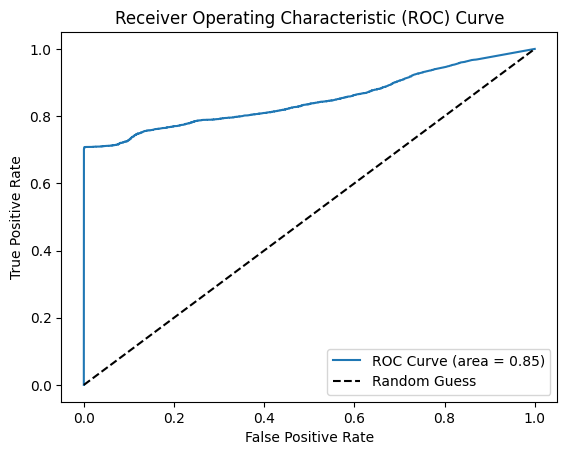

In [ ]:
model, metrics = train_binary_classifier(df_train)

### **The model performs equally well for both labels (label=0 and label=1) with consistent F1 scores, indicating balanced predictions.**

The `predict_with_explanation` function is designed to provide a detailed prediction for whether a specific user (user_id) will like a specific track (track_id)

In [ ]:
def predict_with_explanation(user_id, track_id, data, model, feature_columns):

    entity_row = data[(data['owner_id'] == user_id) & (data['track'] == track_id)]
    if entity_row.empty:
        return {"error": "No matching track found for the given user and track_id."}

    # Extract features for the track
    entity_df = entity_row[feature_columns]

    # Make prediction and probability
    prediction = model.predict(entity_df)[0]
    probability = model.predict_proba(entity_df)[0][1]  # Probability of label = 1

    # Get the true label
    true_label = entity_row['label'].values[0]

    # Explain prediction using feature importances
    feature_importances = model.feature_importances_
    explanation = {
        feature_columns[i]: feature_importances[i] * entity_df.iloc[0, i]
        for i in range(len(feature_columns))
    }

    # If prediction is negative, suggest counterfactuals
    counterfactuals = None
    if prediction == 0:
        # Counterfactual suggestion: Incrementally adjust features to flip prediction
        modified_entity = entity_df.copy()
        for feature in feature_columns:
            original_value = modified_entity[feature].values[0]
            for step in np.linspace(original_value, original_value * 1.5, 10):
                modified_entity[feature] = step
                if model.predict(modified_entity)[0] == 1:
                    counterfactuals = {
                        "feature": feature,
                        "original_value": original_value,
                        "suggested_value": step
                    }
                    break
            if counterfactuals:
                break

    # Return prediction, true label, explanation, and counterfactuals
    return {
        "prediction": prediction,
        "true_label": true_label,
        "probability": probability,
        "explanation": explanation,
        "counterfactuals": counterfactuals
    }


In [ ]:
df_test.head()

,owner_id,genre,track,id,name,artists,release_date,popularity,duration_ms,genres,...,user_preference_energy,user_preference_key,user_preference_loudness,user_preference_mode,user_preference_speechiness,user_preference_acousticness,user_preference_instrumentalness,user_preference_liveness,user_preference_valence,user_preference_tempo
12319,ddog291isboss,Country,65UNQSH7RI4Lxw7VrXMp5y,65UNQSH7RI4Lxw7VrXMp5y,Fraulein (feat. Tyler Childers),"Colter Wall, Tyler Childers",2017-05-12,65,143000,"canadian americana, canadian contemporary coun...",...,0.478404,4.726962,-8.105744,0.866894,0.046054,0.494976,6.061240e-03,0.217409,0.376317,114.751809
24760,ubskwnd3gm7da3k3wrfqfz5jg,Jazz,1hiriMEKwL0t4VwT0aGOsP,1hiriMEKwL0t4VwT0aGOsP,As Erhosoun Gia Ligo,"Dimitris Kalantzis, Athina Routsi",2016-05-30,0,238811,greek swing,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.734723e-18,0.000000,0.000000,0.000000
12409,iliasdeverakis,Country,6ueP6ccf6H5h63WL9kfu23,6ueP6ccf6H5h63WL9kfu23,Obsessed,"Fy, Light, Trannos",2022-07-08,41,216931,greek trap,...,0.726160,5.700000,-6.673040,0.350000,0.119730,0.217144,6.025569e-03,0.174980,0.567810,120.908800
32270,11100700164,Jazz,4HDkMoujyriUWV7Ego9fdZ,4HDkMoujyriUWV7Ego9fdZ,To Mpatiraki,Ekmek,2011-04-06,20,212746,greek indie,...,0.005410,0.033439,0.002493,0.019757,-0.000681,-0.001850,1.962627e-03,-0.000467,0.002494,-1.166877
22091,ansadesigner,Indie,3SXYwUUd5VwoeEBkYuHNBI,3SXYwUUd5VwoeEBkYuHNBI,Memory Loss,Cathedral Bells,2019-02-01,34,145257,"american shoegaze, chill dream pop, grungegaze...",...,0.731309,5.762887,-8.729526,0.628866,0.053530,0.176295,5.890758e-01,0.198432,0.613861,131.060031


Here is a quick test of the function

In [ ]:
feature_columns = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo',  # Song-specific features
    'user_avg_liked_popularity', 'user_avg_liked_duration_ms',
    'user_avg_liked_danceability', 'user_avg_liked_energy',
    'user_avg_liked_key', 'user_avg_liked_loudness', 'user_avg_liked_mode',
    'user_avg_liked_speechiness', 'user_avg_liked_acousticness',
    'user_avg_liked_instrumentalness', 'user_avg_liked_liveness',
    'user_avg_liked_valence', 'user_avg_liked_tempo',
    'user_avg_disliked_popularity', 'user_avg_disliked_duration_ms',
    'user_avg_disliked_danceability', 'user_avg_disliked_energy',
    'user_avg_disliked_key', 'user_avg_disliked_loudness',
    'user_avg_disliked_mode', 'user_avg_disliked_speechiness',
    'user_avg_disliked_acousticness', 'user_avg_disliked_instrumentalness',
    'user_avg_disliked_liveness', 'user_avg_disliked_valence',
    'user_avg_disliked_tempo',
    'user_preference_popularity', 'user_preference_duration_ms',
    'user_preference_danceability', 'user_preference_energy',
    'user_preference_key', 'user_preference_loudness',
    'user_preference_mode', 'user_preference_speechiness',
    'user_preference_acousticness', 'user_preference_instrumentalness',
    'user_preference_liveness', 'user_preference_valence',
    'user_preference_tempo'  # User-specific features
]

# Define a user ID and track ID to predict
user_id = "ubskwnd3gm7da3k3wrfqfz5jg"  # Example user
track_id = "1hiriMEKwL0t4VwT0aGOsP"  # Example track

# Use the predict_with_explanation function
result = predict_with_explanation(user_id, track_id, df_test, model, feature_columns)

print("true_label:", result['true_label'])
# Display the results
if 'error' in result:
    print(result['error'])
else:
    print("Prediction:", result['prediction'])
    print("Probability of Positive Label:", result['probability'])
    print("Explanation (Feature Contributions):")
    for feature, contribution in result['explanation'].items():
        print(f"  {feature}: {contribution:.4f}")

    if result['counterfactuals']:
        print("Counterfactual Suggestion:")
        print(f"  Feature: {result['counterfactuals']['feature']}")
        print(f"  Original Value: {result['counterfactuals']['original_value']}")
        print(f"  Suggested Value: {result['counterfactuals']['suggested_value']}")
    else:
        print("No counterfactuals needed. The prediction is positive.")


true_label: 0
Prediction: 0
Probability of Positive Label: 0.30583333333333335
Explanation (Feature Contributions):
  popularity: 0.0000
  duration_ms: 5516.0875
  danceability: 0.0157
  energy: 0.0132
  key: 0.1018
  loudness: -0.1950
  mode: 0.0038
  speechiness: 0.0007
  acousticness: 0.0142
  instrumentalness: 0.0000
  liveness: 0.0071
  valence: 0.0174
  tempo: 2.9793
  user_avg_liked_popularity: 0.0401
  user_avg_liked_duration_ms: 338.6741
  user_avg_liked_danceability: 0.0016
  user_avg_liked_energy: 0.0033
  user_avg_liked_key: 0.0101
  user_avg_liked_loudness: -0.0163
  user_avg_liked_mode: 0.0014
  user_avg_liked_speechiness: 0.0001
  user_avg_liked_acousticness: 0.0008
  user_avg_liked_instrumentalness: 0.0000
  user_avg_liked_liveness: 0.0003
  user_avg_liked_valence: 0.0008
  user_avg_liked_tempo: 0.3093
  user_avg_disliked_popularity: 0.1788
  user_avg_disliked_duration_ms: 3096.7726
  user_avg_disliked_danceability: 0.0104
  user_avg_disliked_energy: 0.0105
  user_avg_d

The `evaluate_model_performance` function is designed to assess the accuracy of the model by iterating through each row of the test dataset and comparing the model's predictions to the actual labels.

In [ ]:
def evaluate_model_performance(df_test, model, feature_columns):
    correct_predictions = 0
    total_predictions = len(df_test)

    # Iterate through each row with progress bar
    for _, row in tqdm(df_test.iterrows(), total=total_predictions, desc="Evaluating", unit="row"):
        user_id = row['owner_id']
        track_id = row['track']

        # Use predict_with_explanation to get prediction and true label
        result = predict_with_explanation(user_id, track_id, df_test, model, feature_columns)

        if 'error' not in result:
            prediction = result['prediction']
            true_label = result['true_label']

            # Check if the prediction matches the true label
            if prediction == true_label:
                correct_predictions += 1

    # Calculate accuracy percentage
    accuracy_percentage = (correct_predictions / total_predictions) * 100

    print(f"Model Accuracy: {accuracy_percentage:.2f}%")
    return accuracy_percentage


In [ ]:
accuracy = evaluate_model_performance(df_test[:500], model, feature_columns)
print(f"Model Accuracy: {accuracy:.2f}%")

Evaluating: 100%|██████████| 500/500 [25:33<00:00,  3.07s/row]

Model Accuracy: 80.80%
Model Accuracy: 80.80%


The evaluation results show that the model accuracy is 80.80%, meaning that the model correctly predicted whether a user liked or disliked a track for approximately 81% of the test data. Here's a breakdown of the feedback:

## **Conclusion:**
The project aimed to build a binary classifier to predict user preferences for tracks based on Spotify data. Here's a summary of the journey and the achieved outcomes:

**Key Achievements**
1. Data Gathering and Preprocessing:
  * Successfully scraped user and track data using the Spotify API.
  * Engineered meaningful features, including user-specific preferences (e.g., averages for liked and disliked tracks) and track characteristics (e.g., danceability, energy).
2. Model Development:
  * Trained a Random Forest Classifier, which achieved an accuracy of 80.80% on the test set.
  * Evaluated the model with precision, recall, F1 score, and ROC-AUC metrics, indicating balanced performance across both labels (liked/disliked).
3. Explainability:
  * Implemented counterfactual suggestions, which offer actionable insights into how a track could be adjusted to align with a user's preferences.

**Challenges and Limitations**
1. Data Limitations:
  * The dataset relied on assumptions (e.g., counter-genres for disliked tracks) to simulate user preferences, which may not perfectly represent real-world behavior.

**Final Thoughts**

This project demonstrates the power of machine learning to model and predict user preferences. By combining user-specific insights with track-level features, the model achieves a strong foundation for personalized recommendations. While the results are promising, future improvements can further refine its accuracy, scalability, and real-world applicability. This project lays the groundwork for building a user-centric recommendation system that bridges data insights with enhanced user experiences.